## Installation of packages and libraries



In this section we install all the relevant libraries and packages required for the projects.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn import preprocessing
from sklearn import tree
from IPython.display import Image
from sklearn.model_selection import cross_val_score
import pydotplus


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
#Connecting to our data in onedrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading the data

In [ ]:
fake_df=pd.read_csv("/content/drive/My Drive/COS802/train.csv")

In [ ]:
fake_df.head()

In [ ]:
# We remove the rest of the columns and only use text as our feature variable to predict.

fake_df=fake_df.drop(['id','title','author'],axis=1)

In [ ]:
fake_df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
fake_df['text']=fake_df['text'].astype('str')

In [ ]:
pred_data = pd.read_json("/content/drive/My Drive/COS802/FakeNews-Ham.json")
df_pred = pd.DataFrame(pred_data)

In [ ]:
df_pred['label']=1

In [ ]:
df_pred

,published_date,title,text,url,medium,label
0,2019/05/26,WATCH: Women part of Ramaphosa's inauguration,Major Mandisa Mfeka is South Africa's first bl...,http://www.enca.com/life/watch-women-part-rama...,eNCA Online,1
1,2019/08/20,Former SABC interim board members slam SIU rep...,Former SABC interim board members reacted with...,http://www.timeslive.co.za/news/south-africa/2...,The Times,1
2,2018/09/11,White media are the true state capture winners...,The spokesperson for political party Black Fir...,http://citizen.co.za/news/south-africa/2007534...,The Citizen,1
3,2020/01/08,Mkhwebane 'driven by reckless determination to...,Lawyers acting for President Cyril Ramaphosa i...,http://www.news24.com/SouthAfrica/News/mkhweba...,News24,1
4,2019/01/16,2 KZN cops charged with murder after shooting ...,"Mxolisi Mngadi Handcuffs. (Duncan Alfreds, New...",http://www.news24.com/SouthAfrica/News/2-kzn-c...,News24,1
...,...,...,...,...,...,...
99995,2017/01/26,Another 7 licensing centre officials arrested ...,The Hawks on Thursday arrested another seven l...,http://www.sowetanlive.co.za/news/2017/01/26/a...,Sowetan,1
99996,2018/02/06,Durban security guard shot in face during dari...,A security guard is fighting for his life in a...,http://www.timeslive.co.za/news/south-africa/2...,The Times,1
99997,2020/01/13,Elderly man killed in climbing accident in Cap...,An elderly man in his 70s has died in a climbi...,http://citizen.co.za/news/south-africa/acciden...,The Citizen,1
99998,2018/03/05,DRUG DEALER'S CAR TORCHED!,JUST days after police claimed victory in the ...,http://www.dailysun.co.za/News/National/drug-d...,Daily Sun,1


In [ ]:
df_pred=df_pred.drop(['published_date','title','url','medium'],axis=1)

## Word Embeddings

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

we use genism library to train word embeddings

In [ ]:
import gensim

we create a model which outputs X-feature array and y-label tokenized array we return the word2vec model and word indexes.

In [ ]:
def Data2tokenizer(df):
  y = df["label"].values
  #Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
  X = []
  stop_words = set(nltk.corpus.stopwords.words("english"))
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
      sent = sent.lower()
      tokens = tokenizer.tokenize(sent)
      filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
      tmp.extend(filtered_words)
    X.append(tmp)

  w2v_model = gensim.models.Word2Vec(sentences=X, size=100, window=5, min_count=1)

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X)
  X = tokenizer.texts_to_sequences(X)

  word_index = tokenizer.word_index

  X = pad_sequences(X, maxlen=512)

  return X, y, w2v_model,word_index


this model takes gets the model weights of teh word to vec trained model.

In [ ]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix, vocab_size

we use this model to ouput our word embeddings and the size of our vocab

In [ ]:
def EV(w2v_model,word_index):
  embedding_vectors, vocab_size= get_weight_matrix(w2v_model, word_index)
  return embedding_vectors, vocab_size

In [ ]:
embedding_vectors, vocab_size=EV(w2v_model=w2v_model,word_index=word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


##Training & Testing Machine Learning Models.

### Decision Tree Model

In [ ]:
# Building and training the decision tree classifier. with 10 fold CV
classifier = tree.DecisionTreeClassifier()
cv=cross_val_score(classifier, X_train, y_train, cv=10)
classifier = classifier.fit(X_train, y_train, )

In [ ]:
cv

array([0.69423077, 0.71282051, 0.69551282, 0.73525641, 0.70128205,
       0.71538462, 0.72307692, 0.71794872, 0.71666667, 0.68653846])

In [ ]:
#Testing the model on test data set 

y_pred_dt = classifier.predict(X_test) 

In [ ]:
#Prediction accuracy on test data
y_pred_dt

array([0, 1, 1, ..., 0, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred_dt)

0.7092307692307692

In [ ]:

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2588
           1       0.71      0.72      0.71      2612

    accuracy                           0.71      5200
   macro avg       0.71      0.71      0.71      5200
weighted avg       0.71      0.71      0.71      5200



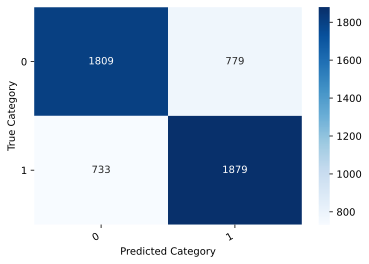

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Category')
  plt.xlabel('Predicted Category');
  
cm = confusion_matrix(y_test, y_pred_dt)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

In [ ]:
# Testing the model prediction on the South African Fake news data set.

y_pred_dt_pred = classifier.predict(X_fake) 

In [ ]:
# Accuracy score on South African fake news data

accuracy_score(y_fake, y_pred_dt_pred)

0.56297

In [ ]:
print(classification_report(y_fake, y_pred_dt_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.56      0.72    100000

    accuracy                           0.56    100000
   macro avg       0.50      0.28      0.36    100000
weighted avg       1.00      0.56      0.72    100000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


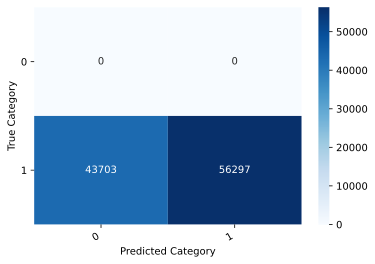

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Category')
  plt.xlabel('Predicted Category');
  
cm = confusion_matrix(y_fake, y_pred_dt_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

## Training and testing LTSM RNN

using the models to determine our tokenized data and word2vec model.

In [ ]:
X, y, w2v_model,word_index=Data2tokenizer(df=fake_df)

In [ ]:
X

array([[    0,     0,     0, ..., 18580, 33889,  3993],
       [    0,     0,     0, ..., 19853,   961, 12735],
       [ 7677,    16,    22, ...,   510,  8321,  8125],
       ...,
       [    0,     0,     0, ...,  4822,  3503,   620],
       [    0,     0,     0, ...,  2551,  4755,  3571],
       [ 1278,    99,    18, ..., 21269,  2072,  3320]], dtype=int32)

In [ ]:
len(X[0])

512

getting our word embeddings for the model.

In [ ]:
embedding_vectors, vocab_size=EV(w2v_model=w2v_model,word_index=word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


training the LTSM model. with ephoc of 10. Use validation to determine best model.

In [ ]:
def LSTMmodel(embedding_vectors,vocab_size):
  model = Sequential()
  #Non-trainable embeddidng layer
  model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=512, trainable=False))
  #LSTM 
  model.add(LSTM(units=128))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
 

  return model

In [ ]:
model=LSTMmodel(embedding_vectors=embedding_vectors,vocab_size=vocab_size)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
history=model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
342/342 [==============================] - 177s 518ms/step - loss: 0.2998 - acc: 0.8777 - val_loss: 0.2295 - val_acc: 0.9158
Epoch 2/10
342/342 [==============================] - 178s 519ms/step - loss: 0.1993 - acc: 0.9231 - val_loss: 0.1929 - val_acc: 0.9248
Epoch 3/10
342/342 [==============================] - 189s 553ms/step - loss: 0.1664 - acc: 0.9358 - val_loss: 0.1797 - val_acc: 0.9316
Epoch 4/10
342/342 [==============================] - 188s 550ms/step - loss: 0.1960 - acc: 0.9221 - val_loss: 0.1885 - val_acc: 0.9259
Epoch 5/10
342/342 [==============================] - 189s 552ms/step - loss: 0.1271 - acc: 0.9516 - val_loss: 0.1379 - val_acc: 0.9483
Epoch 6/10
342/342 [==============================] - 187s 547ms/step - loss: 0.1077 - acc: 0.9605 - val_loss: 0.1402 - val_acc: 0.9464
Epoch 7/10
342/342 [==============================] - 188s 548ms/step - loss: 0.0795 - acc: 0.9707 - val_loss: 0.1424 - val_acc: 0.9474
Epoch 8/10
342/342 [============================

Visualizations of training performance of the model.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
  train_metrics=history.history[metric]
  val_metrics=history.history['val_'+metric]
  ephocs= range(1, len(train_metrics)+1)
  plt.plot(ephocs, train_metrics)
  plt.plot(ephocs, val_metrics)
  plt.title('Training and Validation'+ metric)
  plt.xlabel("Ephocs")
  plt.ylabel(metric)
  plt.legend(["train_"+metric, 'val_'+metric])
  plt.show()

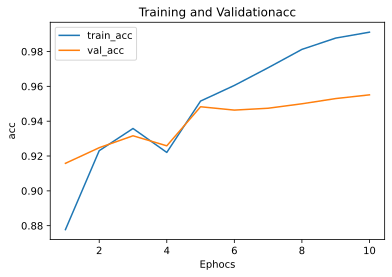

In [ ]:
plot_metric(history, 'acc')

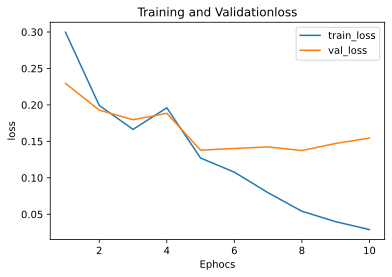

In [ ]:
plot_metric(history, 'loss')

Testing the model perfformance on our test data set.

In [ ]:
y_pred = (history.model.predict(X_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

0.9548076923076924

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2588
           1       0.97      0.94      0.95      2612

    accuracy                           0.95      5200
   macro avg       0.96      0.95      0.95      5200
weighted avg       0.96      0.95      0.95      5200



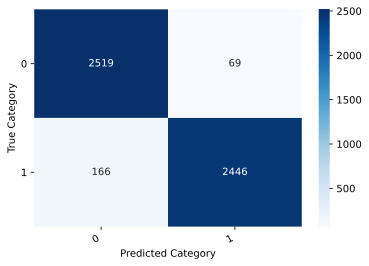

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Category')
  plt.xlabel('Predicted Category');
  
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

## Training & Testing Naive BAyes

In [ ]:
from sklearn.naive_bayes import GaussianNB


In [ ]:
model = GaussianNB()


In [ ]:
 cv_results = cross_val_score(model, X_train, y_train,
                             cv = 10, 
                             scoring = "accuracy",
                             verbose = 2
                            )

Training our Naive Bayes with cross validation of 10.

In [ ]:
cv_results

array([0.48076923, 0.45512821, 0.5       , 0.43589744, 0.48076923,
       0.48076923, 0.46794872, 0.5       , 0.45512821, 0.49358974,
       0.46153846, 0.5       , 0.50641026, 0.49358974, 0.5       ,
       0.49358974, 0.41666667, 0.41666667, 0.44230769, 0.52564103,
       0.55128205, 0.45512821, 0.51282051, 0.49358974, 0.51282051,
       0.38461538, 0.44871795, 0.51923077, 0.50641026, 0.47435897,
       0.52564103, 0.52564103, 0.50641026, 0.46153846, 0.52564103,
       0.47435897, 0.46153846, 0.51282051, 0.51923077, 0.46153846,
       0.46794872, 0.51282051, 0.49358974, 0.49358974, 0.48717949,
       0.53846154, 0.43589744, 0.48076923, 0.42307692, 0.46794872,
       0.46153846, 0.42307692, 0.50641026, 0.42948718, 0.55769231,
       0.47435897, 0.44230769, 0.52564103, 0.50641026, 0.5       ,
       0.47435897, 0.49358974, 0.50641026, 0.51282051, 0.42948718,
       0.3974359 , 0.37179487, 0.42948718, 0.52564103, 0.52564103,
       0.48717949, 0.53205128, 0.44871795, 0.49358974, 0.53205

In [ ]:
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Model performance using the test data.

In [ ]:
predicted= model.predict(X_test) 

In [ ]:
accuracy_score(y_test, predicted)

0.4757692307692308

Model performance using the test data.

In [ ]:
predicted_f= model.predict(X_fake) 

In [ ]:
accuracy_score(y_fake, predicted_f)

0.21157